-----------------------
# Rafi Fadhlillah
# 121450143
# Deep Learning RC
-----------------------

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
from idlmam import set_seed
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn.metrics import accuracy_score
import time
from idlmam import LastTimeStep, train_network, Flatten, weight_reset, View, LambdaLayer
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore
#For attention mechanism use

<ipython-input-3-1a51e7d91cc0>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from IPython.display import display_pdf
from IPython.display import Latex

<ipython-input-4-baeeeeff9ffc>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [5]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
import torchtext
import portalocker
from torchtext.datasets import AG_NEWS
train_iter, test_iter = AG_NEWS(root='./', split=('train', 'test'))
train_dataset = list(train_iter)
test_dataset = list(test_iter)

In [8]:
print(train_dataset[0])
# Output:
# (3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Shortsellers,
# Wall Street's dwindling band of ultra-cynics, are seeing green again.")

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


In [11]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import build_vocab_from_iterator
# Tokenizer
tokenizer = get_tokenizer('basic_english')
# Menghitung frekuensi token dari dataset
def yield_tokens(data_iter):
    # Added indentation here
    for _, text in data_iter:
        # Added indentation here
        yield tokenizer(text)
# Buat vocabulary dari iterator token
vocab = build_vocab_from_iterator(
    yield_tokens(train_dataset),
    specials=['<unk>', '<BOS>', '<EOS>', '<PAD>']
)

In [12]:
# Atur token yang tidak dikenali
vocab.set_default_index(vocab['<unk>'])
print(f"Jumlah kata dalam vocab: {len(vocab)}")
print(f"Contoh indeks kata 'data': {vocab['data']}")

Jumlah kata dalam vocab: 95814
Contoh indeks kata 'data': 268


In [16]:
def text_transform(x): #string -> list of integers
  return [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']] #vocab acts like a dictionary, handls unkown tokens for us,␣and we can make it pre and post-pend with the start and end markers␣respectively.
def label_transform(x):
  return x-1 #labes are originally [1, 2, 3, 4] but we need them as [0, 1, 2,␣3]
#Transform the first data point's text into a list of tokens
print(text_transform(train_dataset[0][1]))

[1, 434, 428, 4, 1608, 14841, 116, 69, 5, 851, 16, 30, 17, 30, 18, 50728, 6, 434, 377, 19, 12, 67510, 9, 52261, 6, 45, 4012, 786, 328, 4, 2]


In [17]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = len(np.unique([z[0] for z in train_dataset]))
print("Vocab: ", VOCAB_SIZE)
print("Num Classes: ", NUM_CLASS)
padding_idx = vocab["<PAD>"]
embed_dim = 128
B = 64
epochs = 5

Vocab:  95814
Num Classes:  4


In [19]:
def pad_batch(batch):

  """
  Pad items in the batch to the length of the longest item in the batch.
  Also, re-order so that the values are returned (input, label)
  """
  labels = [label_transform(z[0]) for z in batch] #get and transform every␣label in the batch
  texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch] #get, tokenizer, and put into a tensor every text
  #what is the longest sequence in this batch?
  max_len = max([text.size(0) for text in texts])
  #pad each text tensor by whatever amount gets it to the max_len
  texts = [F.pad(text, (0,max_len-text.size(0)), value=padding_idx) for text in texts]
  #make x and y a single tensor
  x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)
  return x, y

In [20]:
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

## RNN Sederhana

In [24]:
gru = nn.Sequential(
nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx), #(B, T) -> (B,T, D)
nn.GRU(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D))
LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN␣output and reduce it to one item, (B, 2*D)
nn.Linear(embed_dim*2, NUM_CLASS), #(B, D) -> (B, classes)
)

loss_func = nn.CrossEntropyLoss()
gru_results = train_network(gru, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='val Accuracy'>

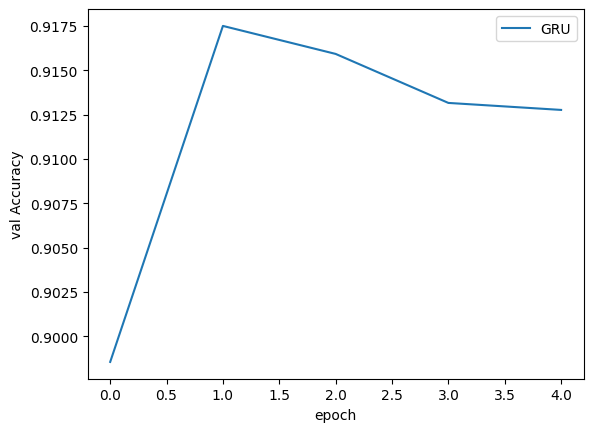

In [25]:
sns.lineplot(x='epoch', y='val Accuracy', data=gru_results, label='GRU')

## Analisis
berdasarkan grafik diatas terlihat bahwa model validasi akurasi semakin meningkat signifikan dari epochs 0 hingga epochs 1 kemudian menurun setelah epochs ke 1 atau seiring dengan bertambahnya epochs yang menandakan adanya overfitting yang mengakibatkan data terlalu bagus saat training namun buruk saat dicobakan ke data test yang baru.

## Positional Encoding

In [27]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    r"""
    Inject some information about the relative or absolute position of the tokens
    in the sequence. The positional encodings have the same dimension as
    the embeddings, so that the two can be summed. Here, we use sine and
    cosine functions of different frequencies.

    .. math::
        \text{PosEncoder}(pos, 2i) = \sin(pos / 10000^{2i / d_{model}})
        \text{PosEncoder}(pos, 2i + 1) = \cos(pos / 10000^{2i / d_{model}})

    where pos is the word position and i is the embedding index.

    Args:
        d_model: the embedding dimension (required).
        dropout: the dropout value (default=0.1).
        max_len: the max length of the incoming sequence (default=5000).
        batch_first: if True, the input tensor shape will be (B, T, D) instead of (T, B, D).

    Example:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000, batch_first=False):
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        self.batch_first = batch_first

        # Create the positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""
        Args:
            x: the sequence fed to the positional encoder model (required).

        Shape:
            x: [sequence length, batch size, embed dim]

        Returns:
            output: [sequence length, batch size, embed dim]

        Example:
            >>> output = pos_encoder(x)
        """
        if self.batch_first:
            # Go from (B, T, D) input shape to (T, B, D)
            x = x.permute(1, 0, 2)

        x = x * np.sqrt(self.d_model) + self.pe[:x.size(0), :]
        x = self.dropout(x)

        if self.batch_first:
            # Now go back to (B, T, D) shape
            x = x.permute(1, 0, 2)

        return x


In [28]:
import torch.nn as nn

simplePosEmbdAvg = nn.Sequential(
    # Embedding layer: (B, T) -> (B, T, D)
    nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx),

    # Positional encoding layer
    PositionalEncoding(embed_dim, batch_first=True),
    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),

    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),

    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),

    # AdaptiveAvgPool2d: (B, T, D) -> (B, 1, D)
    nn.AdaptiveAvgPool2d((1, None)),

    # Flatten: (B, 1, D) -> (B, D)
    nn.Flatten(),

    # Additional linear layers with LeakyReLU and BatchNorm
    nn.Linear(embed_dim, embed_dim),
    nn.LeakyReLU(),

    nn.BatchNorm1d(embed_dim),

    # Final linear layer: (B, D) -> (B, NUM_CLASS)
    nn.Linear(embed_dim, NUM_CLASS)
)


## AdditiveAttention

In [30]:
class AdditiveAttentionScore(nn.Module):

    def __init__(self, D):
        super(AdditiveAttentionScore, self).__init__()
        self.v = nn.Linear(D, 1)
        self.w = nn.Linear(2*D, D)

    def forward(self, states, context):
        """
        states: (B, T, D) shape
        context: (B, D) shape
        output: (B, T, 1), giving a score to each of the T items based on the context D

        """
        T = states.size(1)
        #Repeating the values T times
        context = torch.stack([context for _ in range(T)], dim=1) #(B, D) -> (B, T, D)
        state_context_combined = torch.cat((states, context), dim=2) #(B, T, D) + (B, T, D)  -> (B, T, 2*D)
        scores = self.v(torch.tanh(self.w(state_context_combined)))
        return scores


## nhead = 8

In [31]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import functional as F

class SimpleTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, D, padding_idx=None):
        super(SimpleTransformerClassifier, self).__init__()
        self.padding_idx = padding_idx

        # Embedding layer
        self.embd = nn.Embedding(vocab_size, D, padding_idx=padding_idx)

        # Positional Encoding
        self.position = PositionalEncoding(D, batch_first=True)

        # Transformer Encoder
        self.transformer = TransformerEncoder(
            TransformerEncoderLayer(d_model=D, nhead=8),
            num_layers=3
        )

        # Attention layer
        self.attn = AttentionAvg(AdditiveAttentionScore(D))

        # Prediction layer
        self.pred = nn.Sequential(
            nn.Flatten(),  # (B, 1, D) -> (B, D)
            nn.Linear(D, D),
            nn.LeakyReLU(),
            nn.BatchNorm1d(D),
            nn.Linear(D, NUM_CLASS)
        )

    def forward(self, input):
        # Generate mask for padding
        if self.padding_idx is not None:
            mask = input != self.padding_idx
        else:
            mask = input == input  # All entries are `True`

        # Get embedding and apply positional encoding
        x = self.embd(input)  # (B, T, D)
        x = self.position(x)  # (B, T, D)

        # Transformer expects (T, B, D), so permute the input
        x = self.transformer(x.permute(1, 0, 2))  # (T, B, D)
        x = x.permute(1, 0, 2)  # (B, T, D)

        # Average over time steps, using mask to avoid padding
        context = x.sum(dim=1) / mask.sum(dim=1).unsqueeze(1)

        # Pass through attention and prediction layers
        return self.pred(self.attn(x, context, mask=mask))


# Example usage:
simpleTransformer = SimpleTransformerClassifier(VOCAB_SIZE, embed_dim, padding_idx=padding_idx)
transformer_results = train_network(
    simpleTransformer,
    loss_func,
    train_loader,
    val_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=epochs
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

<Axes: xlabel='total time', ylabel='val Accuracy'>

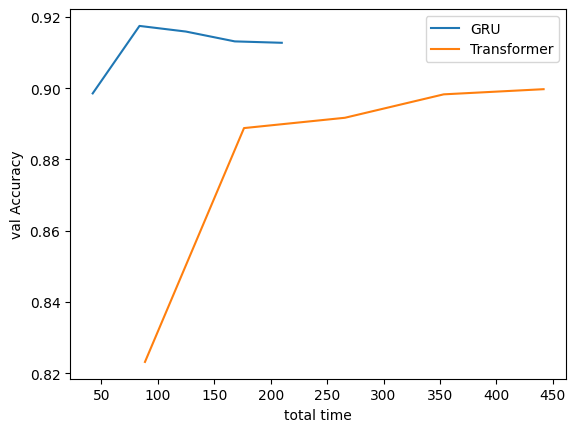

In [32]:
import seaborn as sns

sns.lineplot(x='total time', y='val Accuracy', data=gru_results, label='GRU')
sns.lineplot(x='total time', y='val Accuracy', data=transformer_results, label='Transformer')

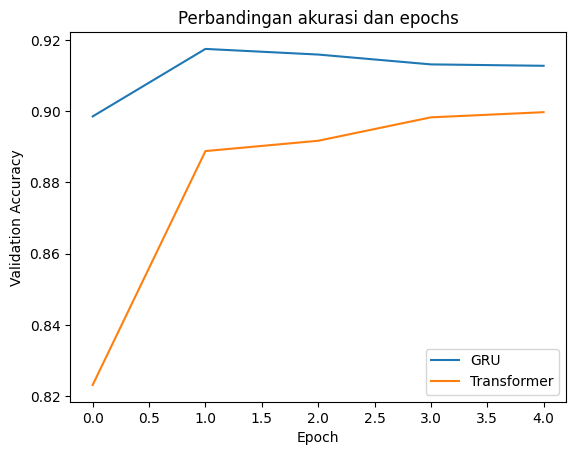

In [35]:
sns.lineplot(x='epoch', y='val Accuracy', data=gru_results, label='GRU')
sns.lineplot(x='epoch', y='val Accuracy', data=transformer_results, label='Transformer')
plt.title('Perbandingan akurasi dan epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

## Analisis
berdasarkan grafik **perbandingan waktu dan akurasi** dari GRU dan Ttransformer terlihat bahwa model GRU secara akurasi lebih tinggi dibandingkan transformer kemudian secara efisiensi waktu komputasi juga lebih efisien dibandingkan dengan transformer, kemudian **berdasarkan epochs** ketika berada di epochs 1 yang merupakan puncak dari GRU maupun transformer juga terlihat bahwa GRU lebih unggul diatas transformer kemudian seiring bertambahnya epochs model gru mengalami sedikit penurunan sedangkan model Transformer mengalami sedikit peningkatan seiring bartambahnya epochs

## Modifikasi Transformer
menambahkan optimizer AdamW dengan weight decay

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

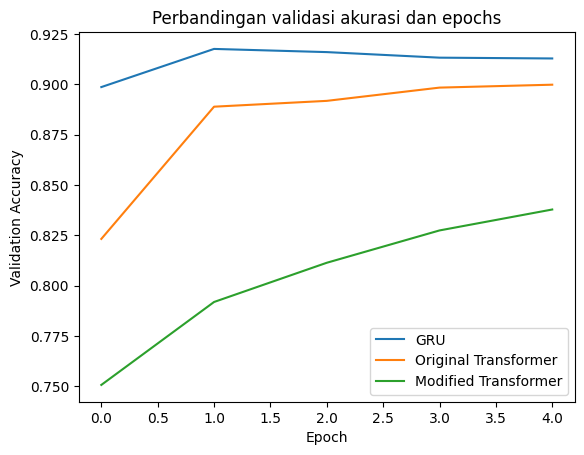

In [39]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class ModifiedTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, D, padding_idx=None, nhead=8, num_layers=3, dropout=0.1):
        super(ModifiedTransformerClassifier, self).__init__()
        self.padding_idx = padding_idx
        self.embd = nn.Embedding(vocab_size, D, padding_idx=padding_idx)
        self.position = PositionalEncoding(D, batch_first=True, dropout=dropout)
        encoder_layer = TransformerEncoderLayer(d_model=D, nhead=nhead, dim_feedforward=2*D, dropout=dropout, activation='gelu') # Increased dim_feedforward and used GELU
        self.transformer = TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.attn = AttentionAvg(AdditiveAttentionScore(D))

        # Modified prediction layer with dropout and LayerNorm
        self.pred = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout), # Added dropout
            nn.Linear(D, D),
            nn.GELU(), # Use GELU instead of LeakyReLU
            nn.LayerNorm(D), # Added LayerNorm
            nn.Linear(D, NUM_CLASS)
        )

    def forward(self, input):
        # Generate mask for padding
        if self.padding_idx is not None:
            mask = input != self.padding_idx
        else:
            mask = input == input  # All entries are `True`

        # Get embedding and apply positional encoding
        x = self.embd(input)  # (B, T, D)
        x = self.position(x)  # (B, T, D)

        # Transformer expects (T, B, D), so permute the input
        x = self.transformer(x.permute(1, 0, 2))  # (T, B, D)
        x = x.permute(1, 0, 2)  # (B, T, D)

        # Average over time steps, using mask to avoid padding
        context = x.sum(dim=1) / mask.sum(dim=1).unsqueeze(1)

        # Pass through attention and prediction layers
        return self.pred(self.attn(x, context, mask=mask))

# Hyperparameter tuning
modified_transformer = ModifiedTransformerClassifier(VOCAB_SIZE, embed_dim, padding_idx=padding_idx, nhead=4, num_layers=4, dropout=0.2) # Increased num_layers, decreased nhead, increased dropout
optimizer = torch.optim.AdamW(modified_transformer.parameters(), lr=5e-5, weight_decay=0.01) # AdamW with weight decay

modified_transformer_results = train_network(
    modified_transformer,
    loss_func,
    train_loader,
    val_loader=test_loader,
    optimizer=optimizer,  # Use the new optimizer
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=epochs
)

sns.lineplot(x='epoch', y='val Accuracy', data=gru_results, label='GRU')
sns.lineplot(x='epoch', y='val Accuracy', data=transformer_results, label='Original Transformer')
sns.lineplot(x='epoch', y='val Accuracy', data=modified_transformer_results, label='Modified Transformer')
plt.title('Perbandingan validasi akurasi dan epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

Hasilnya malah lebih buruk daripada originalnya, sekarang karena grafik transformer meningkat seiring bertambahnya epochs maka kita coba menaikan epochs nya 2 kali lipat menjadi 10

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validating:   0%|          | 0/119 [00:00<?, ?it/s]

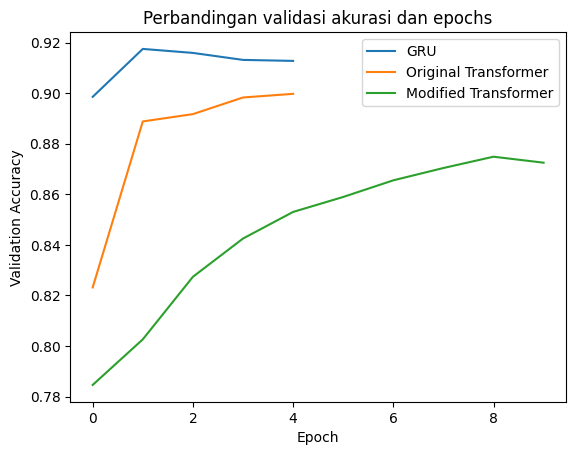

In [41]:
epochs_modified = 10

modified_transformer_results = train_network(
    modified_transformer,
    loss_func,
    train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=epochs_modified
)
sns.lineplot(x='epoch', y='val Accuracy', data=gru_results, label='GRU')
sns.lineplot(x='epoch', y='val Accuracy', data=transformer_results, label='Original Transformer')
sns.lineplot(x='epoch', y='val Accuracy', data=modified_transformer_results, label='Modified Transformer')
plt.title('Perbandingan validasi akurasi dan epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

hasilnya masih lebih buruk :(